In [1]:
!pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.9 MB/s eta 0:00:00


# Imports and configs

In [2]:
from detectron2.data import detection_utils as utils, build_detection_train_loader, DatasetCatalog, MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultTrainer, hooks
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2 import model_zoo
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.notebook import tqdm
import detectron2.data.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import random
import torch
import json
import copy
import cv2
import os

setup_logger()
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    dataset_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
    train_image_path = os.path.join(dataset_path, "train")
    train_label_path = os.path.join(dataset_path, "train_labels.csv")
    sample_sub_path = os.path.join(dataset_path, "sample_submission.csv")

    seed = 42
    n_folds = 5
    current_fold = 0
    
    model_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
    output_dir = model_name.split("/")[1].split(".")[0] + "_fold_" + str(current_fold)
    
    box_size = 64
    checkpoint_period = 500
    eval_period = 500
    warmup_iters = 1000
    max_iter = 10000
    learning_rate = 0.001
    batch_size = 8
    threshold = 0.4

In [4]:
os.makedirs(CFG.output_dir, exist_ok=True)

In [5]:
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data preprocessing

In [6]:
def create_dataset(tomogram_ids, labels):
    dataset_dicts = []
    
    for tomo_id in tqdm(tomogram_ids):
        tomo_motors = labels[labels['tomo_id'] == tomo_id]
        
        if len(tomo_motors) == 0:
            continue
            
        array_shape = [
            tomo_motors['Array shape (axis 0)'].iloc[0],
            tomo_motors['Array shape (axis 1)'].iloc[0],
            tomo_motors['Array shape (axis 2)'].iloc[0]
        ]
        
        tomo_path = os.path.join(CFG.train_image_path, str(tomo_id))
        
        for _, motor in tomo_motors.iterrows():
            z_pos = int(motor['Motor axis 0'])
            y_pos = int(motor['Motor axis 1'])
            x_pos = int(motor['Motor axis 2'])
            
            box_size = CFG.box_size
            x1 = max(0, x_pos - box_size//2)
            y1 = max(0, y_pos - box_size//2)
            x2 = min(array_shape[2], x_pos + box_size//2)
            y2 = min(array_shape[1], y_pos + box_size//2)
            
            slice_path = os.path.join(tomo_path, f"slice_{z_pos:04d}.jpg")
            if not os.path.exists(slice_path):
                continue

            img = cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE)
            height, width = img.shape  
            record = {
                "file_name": slice_path,
                "image_id": f"{tomo_id}_{z_pos}",
                "height": height,
                "width": width,
                "annotations": [
                    {
                        "bbox": [x1, y1, x2, y2],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": 0,
                    }
                ]
            }
            dataset_dicts.append(record)
            
            z_range = 5  # Include 5 slices above and below
            for z_offset in range(-z_range, z_range + 1):
                if z_offset == 0:  # Skip the original slice
                    continue
                    
                adj_z_pos = z_pos + z_offset
                if 0 <= adj_z_pos < array_shape[0]:
                    adj_slice_path = os.path.join(tomo_path, f"{adj_z_pos:04d}.jpg")
                    if os.path.exists(adj_slice_path):
                        adj_record = {
                            "file_name": adj_slice_path,
                            "image_id": f"{tomo_id}_{adj_z_pos}",
                            "height": height,
                            "width": width,
                            "annotations": [
                                {
                                    "bbox": [x1, y1, x2, y2],
                                    "bbox_mode": BoxMode.XYXY_ABS,
                                    "category_id": 0,
                                }
                            ]
                        }
                        dataset_dicts.append(adj_record)
    
    return dataset_dicts

In [7]:
train_labels = pd.read_csv(CFG.train_label_path)
train_labels = train_labels[train_labels["Number of motors"] == 1].reset_index(drop=True)
train_labels["fold"] = -1

split = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train_labels, train_labels['Number of motors'], groups=train_labels["tomo_id"])
for fold_idx, (train_idx, val_idx) in enumerate(split):
    train_labels.loc[val_idx, "fold"] = fold_idx

In [8]:
train_tomo_ids = train_labels[train_labels["fold"] != CFG.current_fold]['tomo_id'].unique()
val_tomo_ids = train_labels[train_labels["fold"] == CFG.current_fold]['tomo_id'].unique()

print(f"Number of training tomograms:   {len(train_tomo_ids)}")
print(f"Number of validation tomograms: {len(val_tomo_ids)}")

Number of training tomograms:   250
Number of validation tomograms: 63


In [9]:
DatasetCatalog.clear()
MetadataCatalog.clear()

DatasetCatalog.register("train", lambda: create_dataset(train_tomo_ids, train_labels))
MetadataCatalog.get("train").set(thing_classes=["motor"])

DatasetCatalog.register("val", lambda: create_dataset(val_tomo_ids, train_labels))
MetadataCatalog.get("val").set(thing_classes=["motor"])

train_dataset = DatasetCatalog.get("train")
train_metadata = MetadataCatalog.get("train")

val_dataset = DatasetCatalog.get("val")
val_metadata = MetadataCatalog.get("val")

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

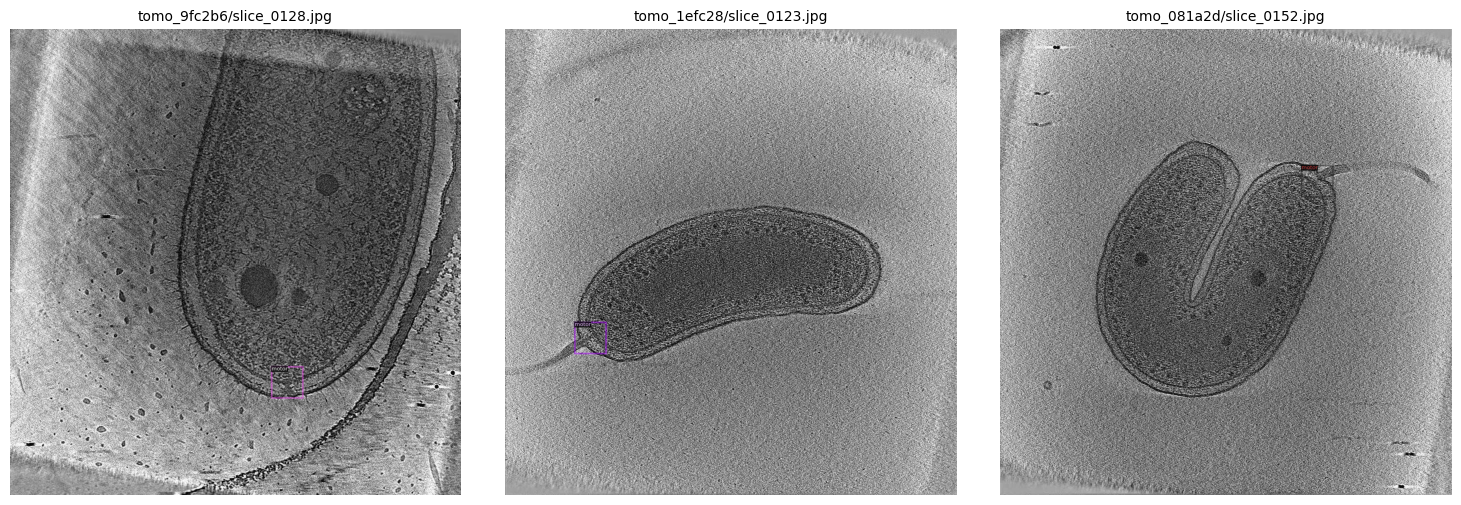

In [10]:
plt.figure(figsize=(15, 5))

samples = random.sample(train_dataset, 3)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    visualizer = Visualizer(img, metadata=train_metadata, scale=1.0)
    vis = visualizer.draw_dataset_dict(sample)

    plt.subplot(1, 3, i + 1)
    plt.imshow(vis.get_image())
    plt.title("/".join(sample["file_name"].split("/")[-2:]), fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Training configs

In [11]:
def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(CFG.model_name))

    cfg.DATASETS.TRAIN = ("train",)
    cfg.DATASETS.TEST = ("val",)

    cfg.INPUT.RANDOM_FLIP = "none"
    cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING = "choice"
    
    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CFG.model_name)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

    cfg.SOLVER.IMS_PER_BATCH = CFG.batch_size
    cfg.SOLVER.BASE_LR = CFG.learning_rate
    cfg.SOLVER.MAX_ITER = CFG.max_iter
    cfg.SOLVER.STEPS = [2000, 4000, 6000, 8000]
    cfg.SOLVER.GAMMA = 0.1
    cfg.SOLVER.WARMUP_ITERS = CFG.warmup_iters
    cfg.SOLVER.CHECKPOINT_PERIOD = CFG.checkpoint_period

    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = CFG.threshold

    cfg.TEST.EVAL_PERIOD = CFG.eval_period

    cfg.OUTPUT_DIR = CFG.output_dir

    return cfg

In [12]:
cfg = setup_cfg()

# Training

In [13]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "evaluation")
        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    
    def build_hooks(self):
        hooks_list = super().build_hooks()
        
        for idx, hook in enumerate(hooks_list):
            if isinstance(hook, hooks.PeriodicCheckpointer):
                hooks_list.pop(idx)
                break
        
        hooks_list.append(
            hooks.BestCheckpointer(
                eval_period=self.cfg.TEST.EVAL_PERIOD,
                checkpointer=DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                val_metric="bbox/AP",
                mode="max",
                file_prefix="best_checkpoint"
            )
        )
        return hooks_list

In [14]:
trainer = Trainer(cfg)

[05/05 09:53:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/250 [00:00<?, ?it/s]

[05/05 09:53:30 d2.data.build]: Removed 0 images with no usable annotations. 250 images left.
[05/05 09:53:30 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   motor    | 250          |
|            |              |
[05/05 09:53:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[05/05 09:53:30 d2.data.build]: Using training sampler TrainingSampler
[05/05 09:53:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 09:53:30 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[05/05 09:53:30 d2.data.common]: Serialized dataset takes 0.07 MiB
[05/05 09:53:30 d2.data.build]: Making batched data loader with batch_size=8


In [15]:
trainer.resume_or_load(resume=False)
trainer.train()

[05/05 09:53:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


model_final_280758.pkl: 167MB [00:00, 194MB/s]                           


[05/05 09:53:31 d2.engine.train_loop]: Starting training from iteration 0
[05/05 09:54:13 d2.utils.events]:  eta: 5:29:33  iter: 19  total_loss: 0.8727  loss_cls: 0.6262  loss_box_reg: 0.0004371  loss_rpn_cls: 0.2519  loss_rpn_loc: 0.02014    time: 1.9757  last_time: 1.9468  data_time: 0.1202  last_data_time: 0.1301   lr: 1.9981e-05  max_mem: 5932M
[05/05 09:55:05 d2.utils.events]:  eta: 5:30:05  iter: 39  total_loss: 0.5719  loss_cls: 0.3201  loss_box_reg: 0.0003926  loss_rpn_cls: 0.2095  loss_rpn_loc: 0.02067    time: 1.9712  last_time: 1.9920  data_time: 0.1090  last_data_time: 0.1027   lr: 3.9961e-05  max_mem: 5932M
[05/05 09:55:44 d2.utils.events]:  eta: 5:29:19  iter: 59  total_loss: 0.3837  loss_cls: 0.1398  loss_box_reg: 0.0125  loss_rpn_cls: 0.187  loss_rpn_loc: 0.02491    time: 1.9666  last_time: 1.9913  data_time: 0.1004  last_data_time: 0.0984   lr: 5.9941e-05  max_mem: 5932M
[05/05 09:56:23 d2.utils.events]:  eta: 5:28:41  iter: 79  total_loss: 0.3324  loss_cls: 0.1371  lo

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 10:10:00 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   motor    | 63           |
|            |              |
[05/05 10:10:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 10:10:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 10:10:00 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 10:10:00 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 10:10:00 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 10:10:00 d2.evaluation.coco_evaluation]: Trying to convert 'val' to COCO format ...
[05/05 10:10:00 d2.data.datasets.coco]: Converting annotations of dat

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 10:10:00 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/05 10:10:00 d2.data.datasets.coco]: Conversion finished, #images: 63, #annotations: 63
[05/05 10:10:00 d2.data.datasets.coco]: Caching COCO format annotations at 'faster_rcnn_R_50_FPN_3x_fold_0/evaluation/val_coco_format.json' ...
[05/05 10:10:00 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 10:10:01 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0492 s/iter. Eval: 0.0003 s/iter. Total: 0.0510 s/iter. ETA=0:00:02
[05/05 10:10:04 d2.evaluation.evaluator]: Total inference time: 0:00:03.016662 (0.052011 s / iter per device, on 1 devices)
[05/05 10:10:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.049306 s / iter per device, on 1 devices)
[05/05 10:10:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 10:10:04 d2.evaluation.coco_evaluation]: Saving results to faster_rcnn_R_50_FPN_3x_fold_0/e

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 10:26:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 10:26:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 10:26:15 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 10:26:15 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 10:26:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 10:26:15 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 10:26:15 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0497 s/iter. Eval: 0.0003 s/iter. Total: 0.0514 s/iter. ETA=0:00:02
[05/05 10:26:18 d2.evaluation.evaluator]: Total inference time: 0:00:03.039546 (0.052406 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 10:42:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 10:42:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 10:42:31 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 10:42:31 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 10:42:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 10:42:31 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 10:42:32 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0016 s/iter. Inference: 0.0494 s/iter. Eval: 0.0002 s/iter. Total: 0.0512 s/iter. ETA=0:00:02
[05/05 10:42:34 d2.evaluation.evaluator]: Total inference time: 0:00:03.065373 (0.052851 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 10:58:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 10:58:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 10:58:51 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 10:58:51 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 10:58:51 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 10:58:51 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 10:58:51 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0488 s/iter. Eval: 0.0002 s/iter. Total: 0.0506 s/iter. ETA=0:00:02
[05/05 10:58:54 d2.evaluation.evaluator]: Total inference time: 0:00:03.002853 (0.051773 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 11:15:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 11:15:09 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 11:15:09 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 11:15:09 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 11:15:09 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 11:15:09 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 11:15:10 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0014 s/iter. Inference: 0.0489 s/iter. Eval: 0.0002 s/iter. Total: 0.0505 s/iter. ETA=0:00:02
[05/05 11:15:12 d2.evaluation.evaluator]: Total inference time: 0:00:03.021521 (0.052095 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 11:31:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 11:31:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 11:31:26 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 11:31:26 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 11:31:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 11:31:26 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 11:31:27 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0497 s/iter. Eval: 0.0002 s/iter. Total: 0.0514 s/iter. ETA=0:00:02
[05/05 11:31:30 d2.evaluation.evaluator]: Total inference time: 0:00:03.065713 (0.052857 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 11:47:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 11:47:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 11:47:45 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 11:47:45 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 11:47:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 11:47:45 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 11:47:46 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0497 s/iter. Eval: 0.0003 s/iter. Total: 0.0515 s/iter. ETA=0:00:02
[05/05 11:47:48 d2.evaluation.evaluator]: Total inference time: 0:00:03.162260 (0.054522 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 12:04:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 12:04:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 12:04:05 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 12:04:05 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 12:04:05 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 12:04:05 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 12:04:06 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0495 s/iter. Eval: 0.0002 s/iter. Total: 0.0512 s/iter. ETA=0:00:02
[05/05 12:04:09 d2.evaluation.evaluator]: Total inference time: 0:00:03.141940 (0.054171 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 12:20:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 12:20:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 12:20:18 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 12:20:18 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 12:20:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 12:20:18 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 12:20:19 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0500 s/iter. Eval: 0.0002 s/iter. Total: 0.0517 s/iter. ETA=0:00:02
[05/05 12:20:22 d2.evaluation.evaluator]: Total inference time: 0:00:03.059183 (0.052745 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 12:36:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 12:36:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 12:36:39 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 12:36:39 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 12:36:39 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 12:36:39 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 12:36:39 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0500 s/iter. Eval: 0.0002 s/iter. Total: 0.0517 s/iter. ETA=0:00:02
[05/05 12:36:42 d2.evaluation.evaluator]: Total inference time: 0:00:03.047885 (0.052550 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 12:52:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 12:52:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 12:52:57 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 12:52:57 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 12:52:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 12:52:57 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 12:52:57 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0019 s/iter. Inference: 0.0502 s/iter. Eval: 0.0002 s/iter. Total: 0.0522 s/iter. ETA=0:00:02
[05/05 12:53:00 d2.evaluation.evaluator]: Total inference time: 0:00:03.086337 (0.053213 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 13:09:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 13:09:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 13:09:15 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 13:09:15 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 13:09:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 13:09:15 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 13:09:16 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0016 s/iter. Inference: 0.0500 s/iter. Eval: 0.0002 s/iter. Total: 0.0518 s/iter. ETA=0:00:02
[05/05 13:09:18 d2.evaluation.evaluator]: Total inference time: 0:00:03.069539 (0.052923 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 13:25:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 13:25:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 13:25:34 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 13:25:34 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 13:25:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 13:25:34 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 13:25:35 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0014 s/iter. Inference: 0.0493 s/iter. Eval: 0.0002 s/iter. Total: 0.0508 s/iter. ETA=0:00:02
[05/05 13:25:38 d2.evaluation.evaluator]: Total inference time: 0:00:03.034305 (0.052316 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 13:41:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 13:41:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 13:41:52 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 13:41:52 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 13:41:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 13:41:52 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 13:41:53 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0499 s/iter. Eval: 0.0002 s/iter. Total: 0.0516 s/iter. ETA=0:00:02
[05/05 13:41:56 d2.evaluation.evaluator]: Total inference time: 0:00:03.037299 (0.052367 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 13:58:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 13:58:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 13:58:06 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 13:58:06 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 13:58:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 13:58:06 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 13:58:07 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0501 s/iter. Eval: 0.0002 s/iter. Total: 0.0519 s/iter. ETA=0:00:02
[05/05 13:58:09 d2.evaluation.evaluator]: Total inference time: 0:00:03.050443 (0.052594 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 14:14:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 14:14:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 14:14:24 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 14:14:24 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 14:14:24 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 14:14:24 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 14:14:24 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0016 s/iter. Inference: 0.0495 s/iter. Eval: 0.0002 s/iter. Total: 0.0513 s/iter. ETA=0:00:02
[05/05 14:14:27 d2.evaluation.evaluator]: Total inference time: 0:00:03.024312 (0.052143 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 14:30:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 14:30:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 14:30:42 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 14:30:42 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 14:30:42 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 14:30:42 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 14:30:43 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0014 s/iter. Inference: 0.0500 s/iter. Eval: 0.0002 s/iter. Total: 0.0516 s/iter. ETA=0:00:02
[05/05 14:30:45 d2.evaluation.evaluator]: Total inference time: 0:00:03.046499 (0.052526 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 14:46:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 14:46:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 14:46:57 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 14:46:57 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 14:46:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 14:46:57 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 14:46:58 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0015 s/iter. Inference: 0.0493 s/iter. Eval: 0.0002 s/iter. Total: 0.0510 s/iter. ETA=0:00:02
[05/05 14:47:01 d2.evaluation.evaluator]: Total inference time: 0:00:03.078392 (0.053076 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 15:03:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 15:03:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 15:03:16 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 15:03:16 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 15:03:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 15:03:16 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 15:03:17 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0014 s/iter. Inference: 0.0493 s/iter. Eval: 0.0002 s/iter. Total: 0.0509 s/iter. ETA=0:00:02
[05/05 15:03:20 d2.evaluation.evaluator]: Total inference time: 0:00:03.060808 (0.052773 s / iter per device, on 1 de

  0%|          | 0/63 [00:00<?, ?it/s]

[05/05 15:19:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 15:19:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 15:19:34 d2.data.common]: Serializing 63 elements to byte tensors and concatenating them all ...
[05/05 15:19:34 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [05/05 15:19:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 15:19:34 d2.evaluation.evaluator]: Start inference on 63 batches
[05/05 15:19:34 d2.evaluation.evaluator]: Inference done 11/63. Dataloading: 0.0016 s/iter. Inference: 0.0494 s/iter. Eval: 0.0002 s/iter. Total: 0.0512 s/iter. ETA=0:00:02
[05/05 15:19:37 d2.evaluation.evaluator]: Total inference time: 0:00:03.012717 (0.051943 s / iter per device, on 1 de

In [16]:
metrics = []
for line in open(f"{CFG.output_dir}/metrics.json"):
    metrics.append(json.loads(line))
    
metrics = pd.DataFrame(metrics)

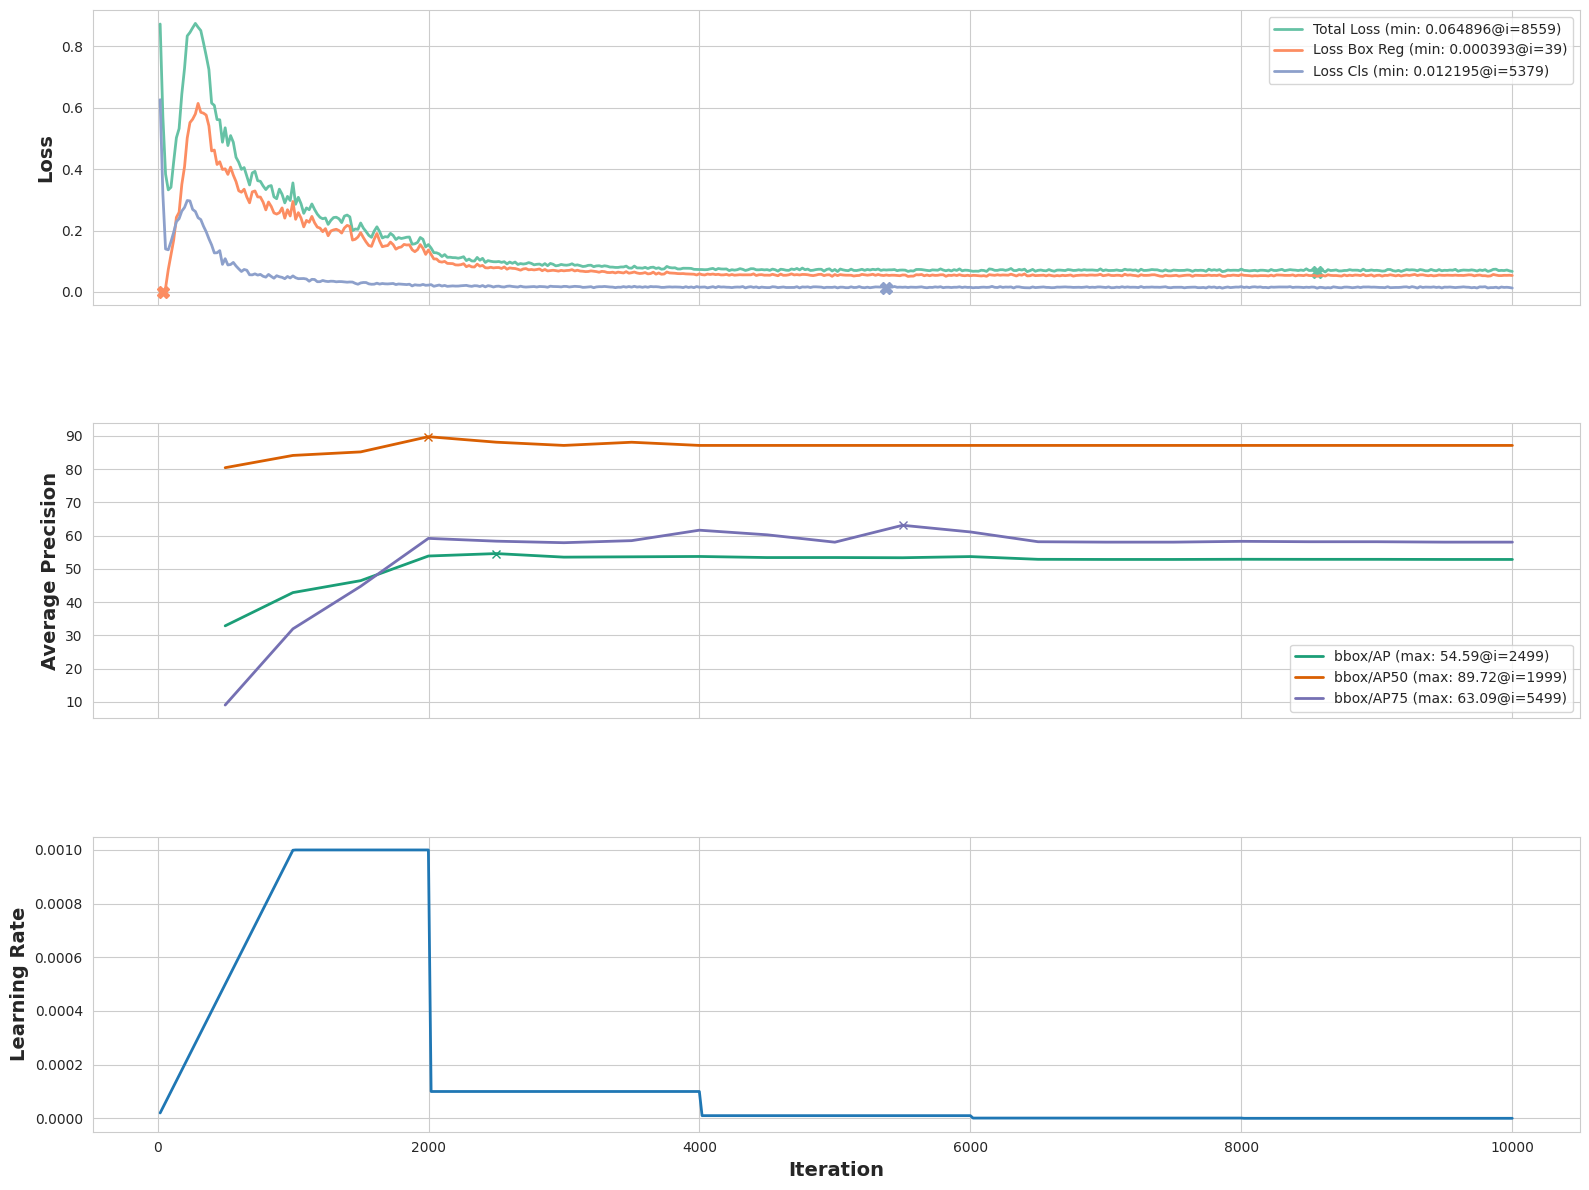

In [17]:
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

colors1 = sns.color_palette("Set2", n_colors=3)
for idx, col in enumerate(["total_loss", "loss_box_reg", "loss_cls"]):
    min_val = metrics[col].min()
    min_row = metrics.loc[metrics[col].idxmin()]
    label = f"{col.replace('_', ' ').title()} (min: {min_val:.6f}@i={int(min_row.iteration)})"
    sns.lineplot(x="iteration", y=col, ax=ax1, data=metrics, linewidth=2, label=label, color=colors1[idx])
    ax1.plot(min_row["iteration"], min_row[col], marker="X", markersize=8, color=colors1[idx])

ax1.set_ylabel("Loss", fontsize=14, weight='bold')
ax1.legend(loc="upper right", frameon=True)
ax1.grid(True)

colors2 = sns.color_palette("Dark2", n_colors=3)
for idx, col in enumerate(["bbox/AP", "bbox/AP50", "bbox/AP75"]):
    max_val = metrics[col].max()
    max_row = metrics.loc[metrics[col].idxmax()]
    label = f"{col} (max: {max_val:.2f}@i={int(max_row.iteration)})"
    sns.lineplot(x="iteration", y=col, ax=ax2, data=metrics, linewidth=2, label=label, color=colors2[idx])
    ax2.plot(max_row["iteration"], max_row[col], marker="x", markersize=6, color=colors2[idx])

ax2.set_ylabel("Average Precision", fontsize=14, weight='bold')
ax2.legend(loc="lower right", frameon=True)
ax2.grid(True)

sns.lineplot(x="iteration", y="lr", ax=ax3, linewidth=2, data=metrics, color="tab:blue")
ax3.set_ylabel("Learning Rate", fontsize=14, weight='bold')
ax3.grid(True)


plt.xlabel("Iteration", fontsize=14, weight='bold')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()
